In [1397]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt
import scipy
import matplotlib.cm as cm
import skimage

# Сатурн

In [1398]:
img = cv2.imread('Saturn.jpg')
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

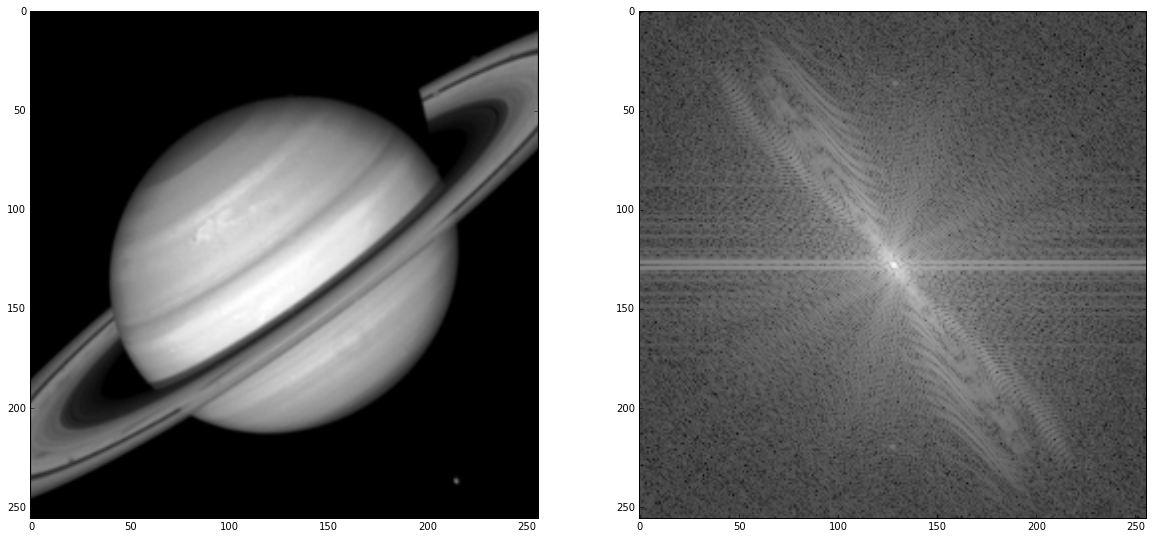

In [1408]:
res = scipy.fftpack.fft2(imgGray)
resShift = scipy.fftpack.fftshift(res)
resShift1 = resShift
resShiftLow = resShift
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(img) 

plt.subplot(2,2,2)
plt.imshow(20*np.log(np.abs(resShift)), cmap='gray')

### Зануляем самые низкие частоты
#### Остаются высокие частоты, которые соответствуют границам

In [1400]:
shape = img.shape
crow,ccol = shape[0]/2 , shape[1]/2
resShift[crow-10:crow+10, ccol-10:ccol+10] = 0
iresShift = np.fft.ifftshift(resShift)
ires= np.fft.ifft2(iresShift)


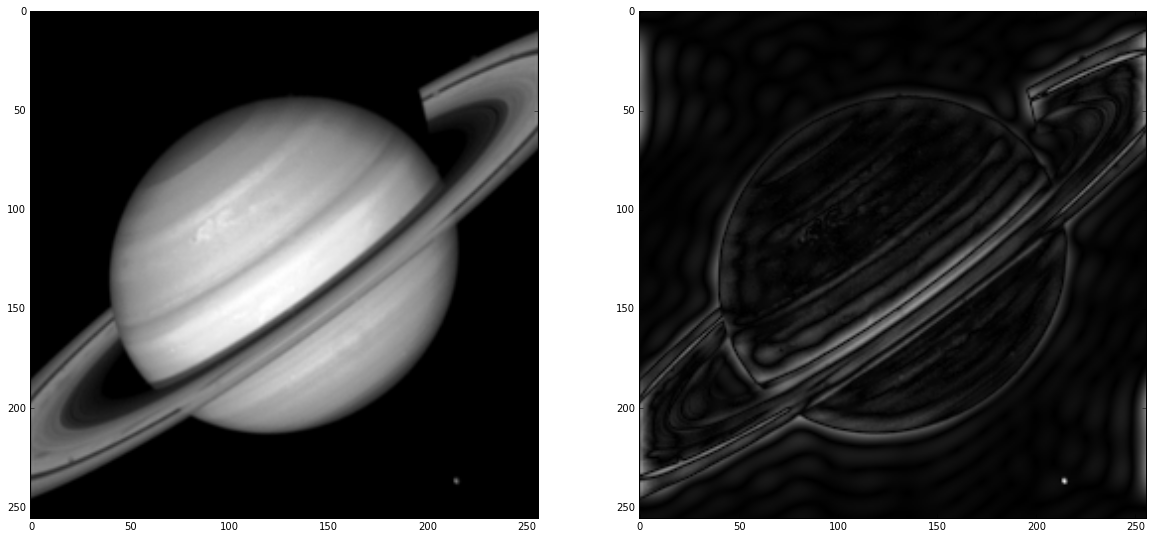

In [1401]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(img) 

plt.subplot(2,2,2)
plt.imshow((np.abs(ires)), cmap='gray')

### Оставляем низкие частоты

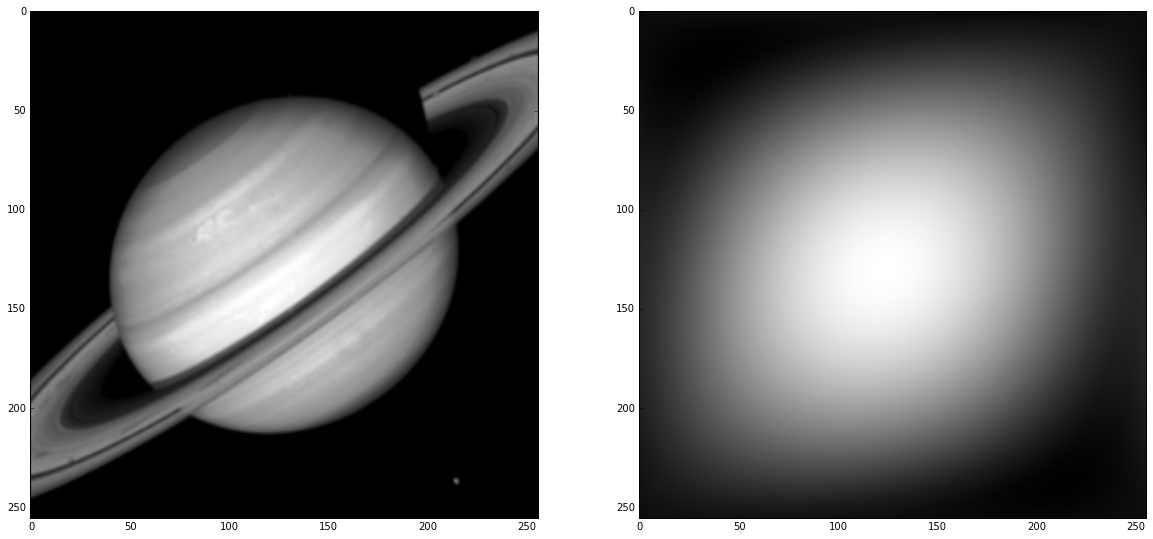

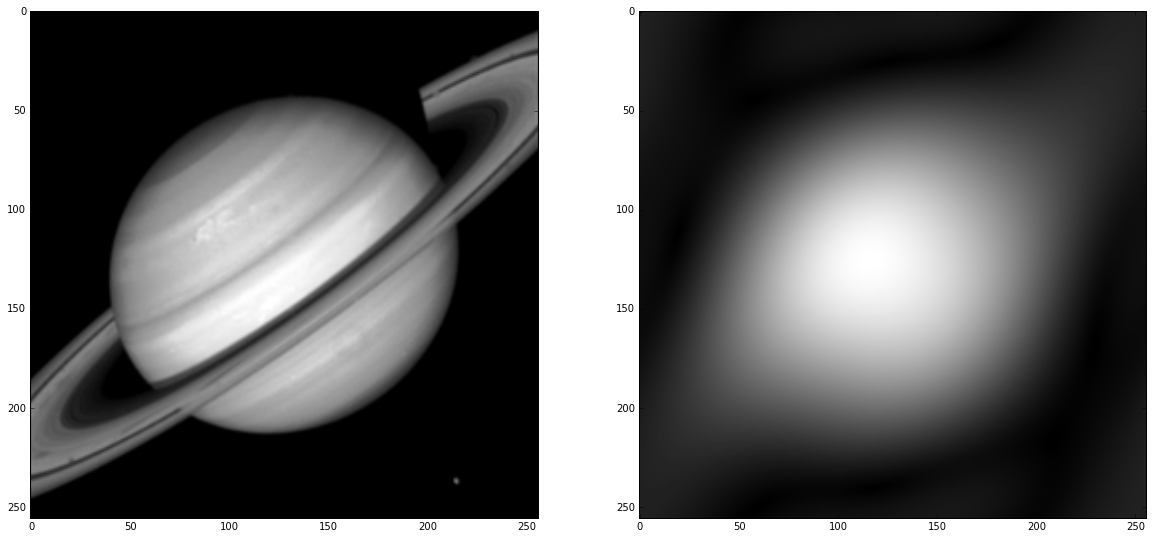

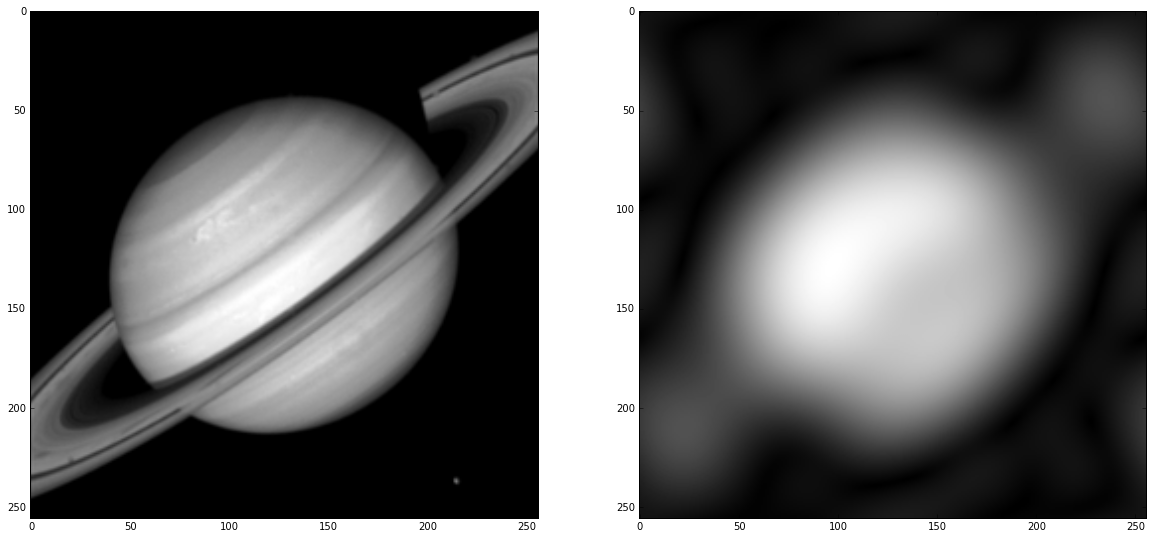

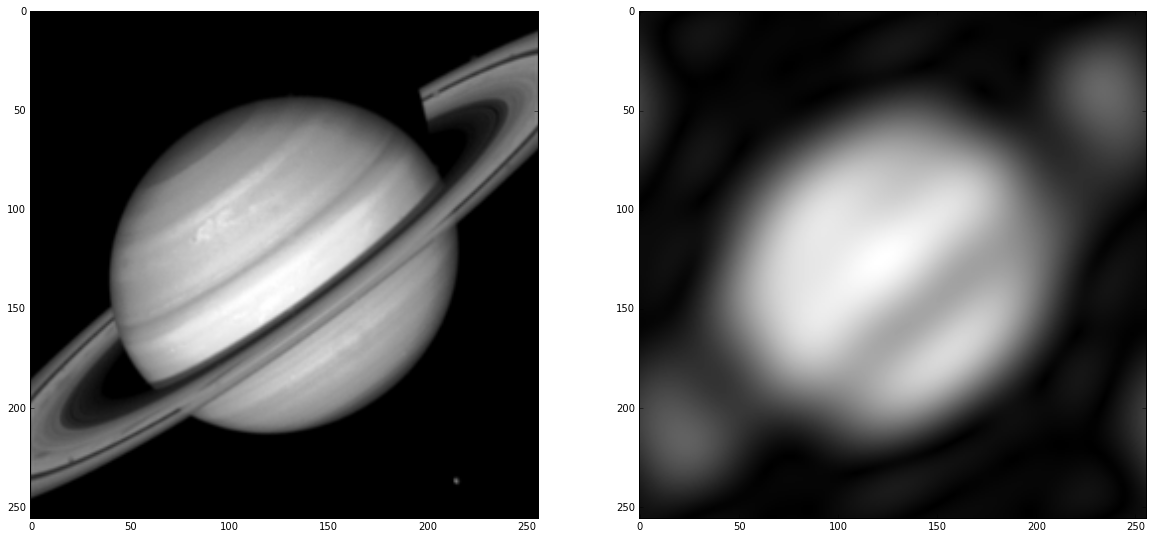

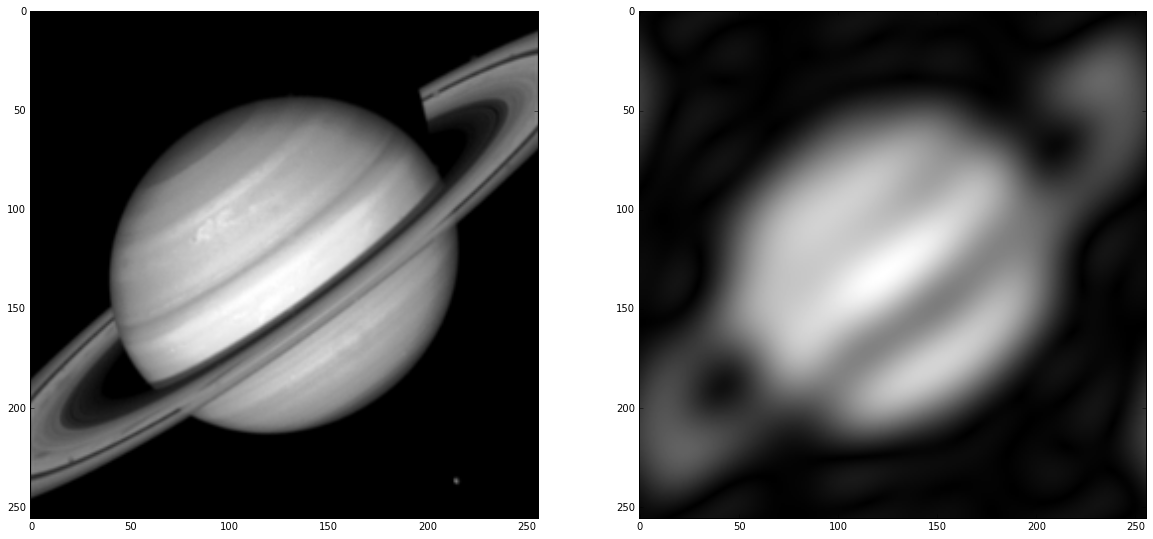

In [1447]:
for i in range(1, 6):
    low = np.zeros((img.shape[0],img.shape[1]), np.complex)
    low[ccol-i:ccol+i, ccol-i:ccol+i] = resShiftLow[ccol-i:ccol+i, ccol-i:ccol+i]
    ilowShift = np.fft.ifftshift(low)
    ilow= np.fft.ifft2(ilowShift )
    
    plt.figure(figsize=(20,20))
    plt.subplot(2,2,1)
    plt.imshow(img) 
    plt.subplot(2,2,2)
    plt.imshow((np.abs(ilow)), cmap='gray')


# Клады

In [1449]:
from skimage.measure import *
from skimage.color import label2rgb
from math import tan
import math

In [1454]:
klads = [cv2.imread('Klad00.jpg'), cv2.imread('Klad01.jpg'),cv2.imread('Klad02.jpg')]
kladsColored = [cv2.cvtColor(klad, cv2.COLOR_BGR2RGB) for klad in klads] 
klads = [cv2.cvtColor(klad, cv2.COLOR_BGR2GRAY) for klad in klads] 

In [1455]:
def check_binarization(fileName, val):
    ret,thresh1 = cv2.threshold(fileName,val,255,cv2.THRESH_BINARY)
    
    plt.figure(figsize=(20,20))
    plt.subplot(2,2,1)
    plt.imshow(fileName,cmap='gray') 

    plt.subplot(2,2,2)
    plt.imshow(thresh1,cmap='gray')
    return thresh1

## Бинаризация
####  Порог - 20

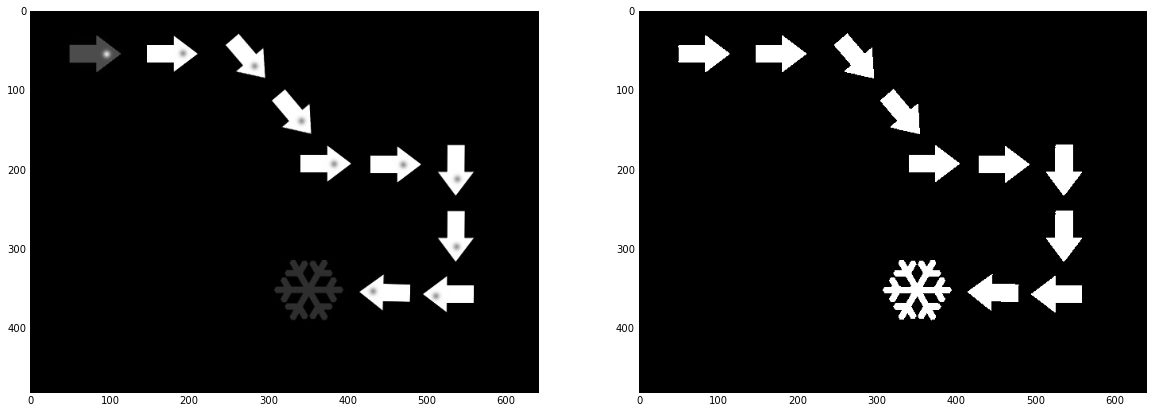

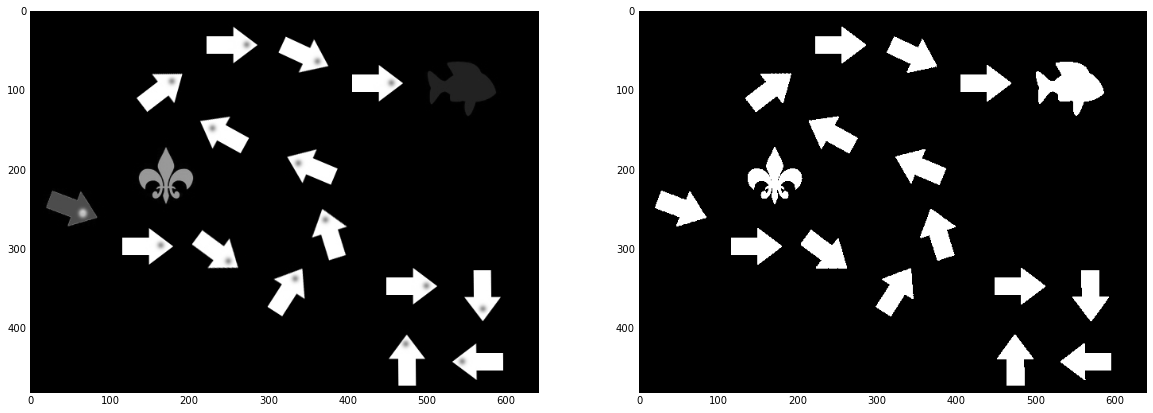

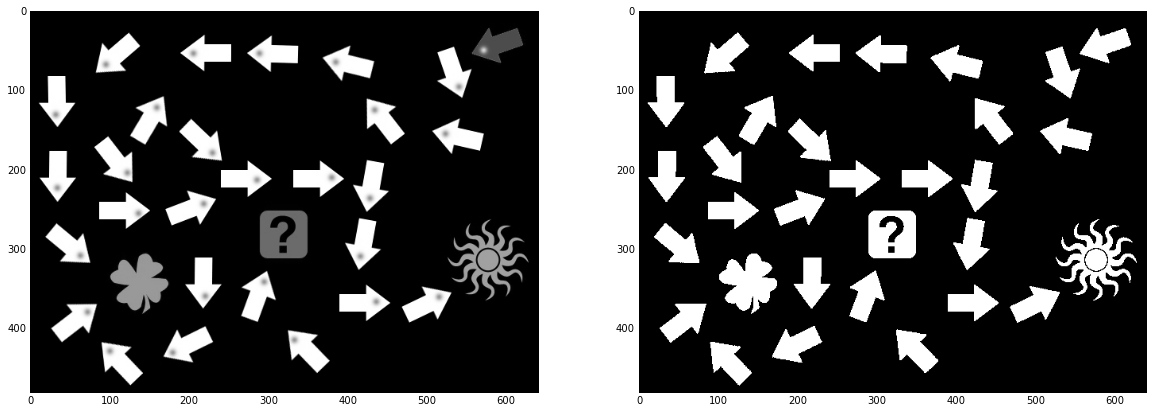

In [1456]:
thres = []
for klad in klads:
    thres.append(check_binarization(klad, 20))

In [1457]:
def getLabel(img, thres):
    imgGray = img
    labelToRet = label(thres)
    """
    toDraw = label2rgb(labelToRet)
    plt.figure(figsize=(20,20))
    plt.title('Histogram of IQ')
    plt.subplot(2,2,1)
    plt.imshow(imgGray,cmap='gray') 

    plt.subplot(2,2,2)
    plt.imshow(toDraw,cmap='gray')
    """
    return labelToRet

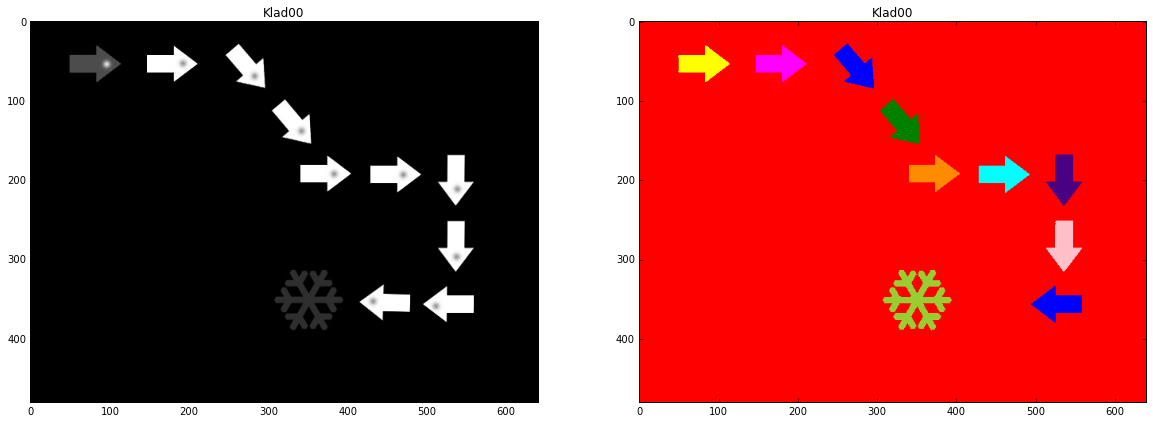

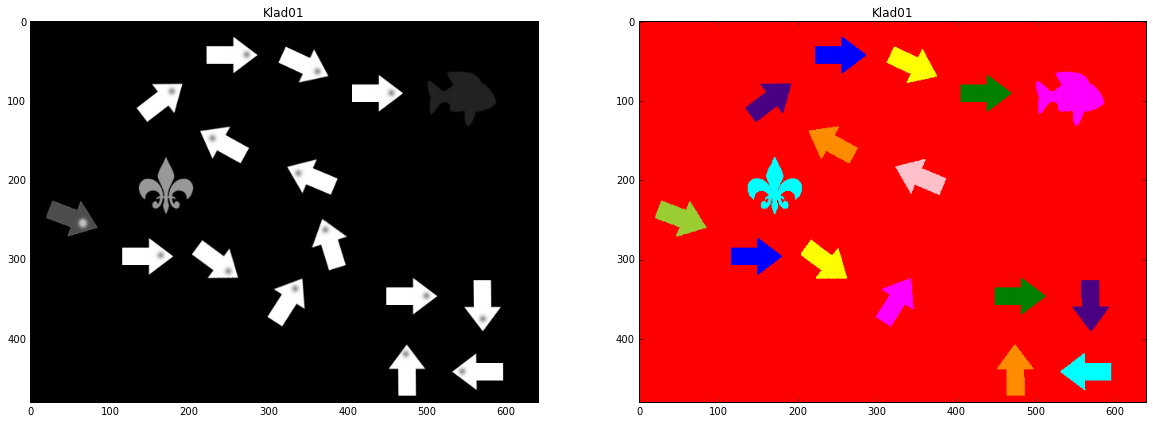

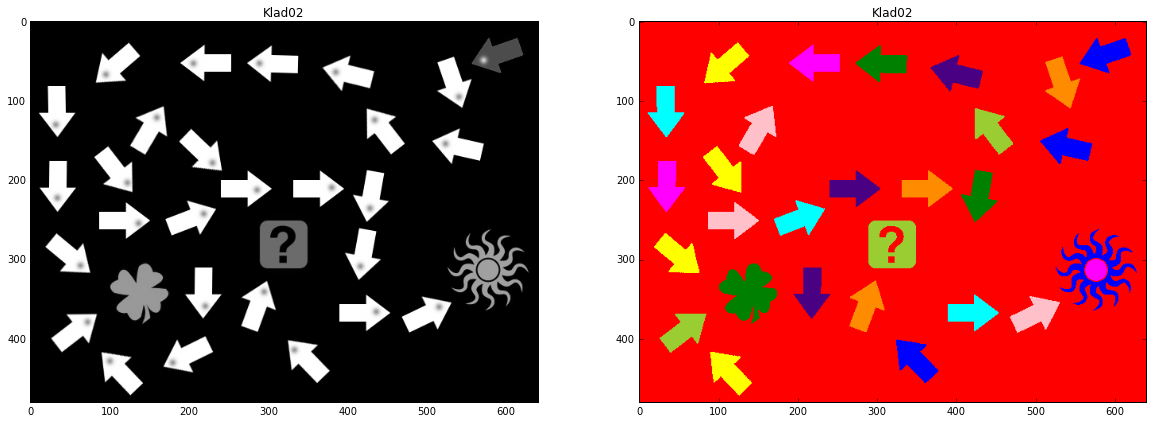

In [1459]:
for i, klad in enumerate(klads):
    labelToRet = getLabel(klad, thres[i])
    toDraw = label2rgb(labelToRet)
    
    plt.figure(figsize=(20,20))
   
    plt.subplot(2,2,1)
    plt.title('Klad0' + str(i))
    plt.imshow(klad,cmap='gray') 

    plt.subplot(2,2,2)
    plt.title('Klad0' + str(i))
    plt.imshow(toDraw,cmap='gray')
    

In [1462]:
#стрелки вытянуты вдоль какого-то направления сильнее, чем остальные встречающиеся на изображениях объекты
def findKladLabel(properties):
    labels = []
    for prop in properties:
        if prop['eccentricity'] < 0.8:
            labels.append( prop['label'])
    return labels

In [1463]:
#стартовая стрелка красная
def getStartArrow(properties, img):
    maxLabel = None
    maxCount = 0 
    for prop in properties:
        
        for point in prop['coords']:
            count = 0
            color = map(int, img[point[0]][point[1]])
            if (color[0] > color[1] + color[2]):
                count += 1 
        if (count > maxCount):
            maxCount = count
            maxLabel = prop['label']
    return maxLabel

In [1376]:
#точки, вдоль главной оси стрелки
def getPath(orientation, x_start, y_start, x_end, y_end):
   
    angle = orientation + math.radians(90) if orientation < 0 else orientation - math.radians(90)
    l = 1 if angle > 0 else -1

    points = []
    if (abs(abs(angle) - math.radians(90)) > 0.1):
        direction = -1 if x_start > x_end else 1
        k = (tan(angle))
        b = y_start - k*x_start 
        
        x_0 = x_start
        y_0 = int(k*x_0+b)
        points.append([x_0, y_0])
        
        delta = -0.5
        for x in range(x_start, x_end, direction):
            points.append([x, int(k*x+b)])          
    else:
        direction = -1 if y_start > y_end else 1
        points = [[x_start, y] for y in range(y_start, y_end, direction)]          
    return points

In [1377]:
#Направление стрелки обозначено зеленой точкой:
#проверяем, с какой стороны от центра масса вдоль основной оси расположено больше зеленых точек

def getGreenPixelsCount(points, img):
    count = 0
    for point in points:
        color = map(int, img[point[0]][point[1]])
        if (color[1] > color[0] + color[2]):
            count += 1 
    return count

def getDirection(leftPoints, rightPoints, img):
    leftGreenCount = getGreenPixelsCount(leftPoints, img)
    
    rightGreenCount = getGreenPixelsCount(rightPoints, img)
    if (leftGreenCount > rightGreenCount):
        x_start, y_start, x_end, y_end = leftPoints[-1][0] - 1, leftPoints[-1][1] -1, 0, 0
    else:
        x_start, y_start, x_end, y_end = rightPoints[-1][0] + 1, rightPoints[-1][1] +1, img.shape[0], img.shape[1]
    return [x_start, y_start, x_end, y_end]

In [1464]:
#Двигаемся вдоль выбранного направления, пока не наткнемся на точки, принадлежащие другой выделенной компоненте
def makeStep(orientation, bbox, coords, points):
    x_start, y_start, x_end, y_end = bbox
    
    angle = orientation + math.radians(90) if orientation < 0 else orientation - math.radians(90)
    l = 1 if angle > 0 else -1
    if (abs(abs(angle) - math.radians(90)) > 0.1):
        #print angle
        direction = -1 if x_start > x_end else 1 
        k = tan(angle)
        #print k
        b = y_start - k*x_start
           
        x_0 = x_start
        y_0 = int(k*x_0+b)
        
        points.append([x_0, y_0])
        prevPoint = [x_0, y_0]
        
        delta = -0.5
        for x in range(x_start, x_end, direction):
            delta += k*l
            y = prevPoint[1]
            if (delta > 0):
                y += 1*direction *l          
                delta -= 1 
                
            prevPoint = [x, y]
            points.append([x, y])
            #points.append([x, int(k*x+b)])
            for block in coords:
                if (x > block[0][0]) and (x < block[0][2]) and (y > block[0][1]) and (y < block[0][3]):
                    return block[-1]
                
            
    else:
        direction =  -1 if y_start > y_end else 1
        for y in range(y_start, y_end, direction):
            for block in coords:
                points.append([x_start, y])
                if (x_start > block[0][0]) and (x_start < block[0][2]) and (y > block[0][1]) and (y < block[0][3]):
                    return block[-1]
    

In [1465]:
#Двигаемся по стрелкам, пока не дойдем до компоненты, которая не является стрелкой
def findKlad(arrowDirections, startArrowLabel, coords, kladPropertyLabels):
    arrow = arrowDirections[startArrowLabel]
    curLabel = startArrowLabel
    path = [curLabel]
    points = []
    while (curLabel not in kladPropertyLabels):
        arrow = arrowDirections[curLabel]
        curLabel = makeStep(arrow[0], arrow[1], coords, points)     
        path.append(curLabel)
    return path, points 

In [1388]:
def process(kladNumber):
    lab = getLabel(klads[kladNumber], thres[kladNumber])
    properties = regionprops(lab)
    kladPropertyLabels = findKladLabel(properties)
    startArrowLabel = getStartArrow(properties, kladsColored[kladNumber])
    arrowDirections = {}
    for prop in properties:
        x_m, y_m = map(int, prop['centroid'])
        x_min, y_min, x_max, y_max = map(int, prop['bbox'])
         
        rightPoints = getPath(prop['orientation'], x_m, y_m, x_max, y_max )
        leftPoints = getPath(prop['orientation'], x_m, y_m, x_min, y_min )
        arrowDirections[prop['label']] = [prop['orientation'],
                                getDirection(leftPoints, rightPoints, kladsColored[kladNumber])]
   
    coords = [[map(int, prop["bbox"]), prop['label']] for prop in properties]

    labelsPath, points = findKlad(arrowDirections, startArrowLabel, coords, kladPropertyLabels)
    drawResults(points, labelsPath, kladNumber, properties)
    

In [1468]:
import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw

In [1469]:
def drawResults(points, path, kladNumber, properties):
    img = kladsColored[kladNumber].copy()
    for point in points:
        img[point[0]][point[1]] = [255, 255,255]
    resultFile = "Klad" + str(kladNumber) + "Result.png"
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(resultFile, img)
    
    img = Image.open(resultFile)
    draw = ImageDraw.Draw(img)
    for i, label in enumerate(path):
        x_m, y_m = map(int, properties[label-1]['centroid'])
        draw.text((y_m, x_m), str(i), (128,0,0))
    draw = ImageDraw.Draw(img)    
    img.save(resultFile)
    
    result = cv2.imread(resultFile)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20,20))
    plt.subplot(2,2,1)
    plt.title("Klad0" + str(kladNumber))
    plt.imshow(result,cmap='gray')

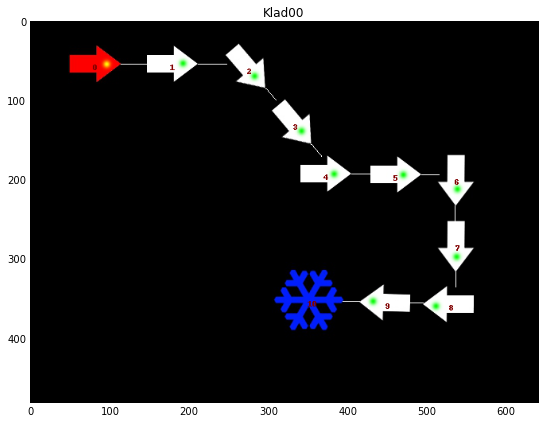

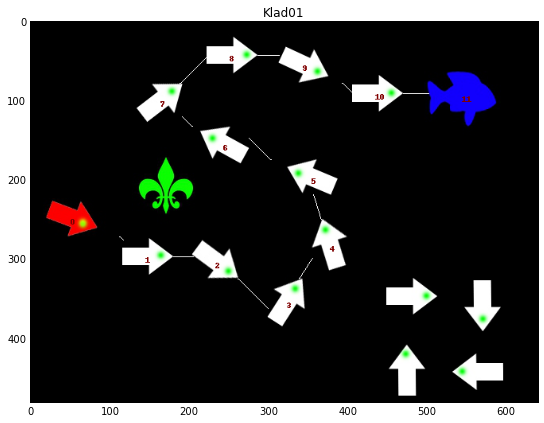

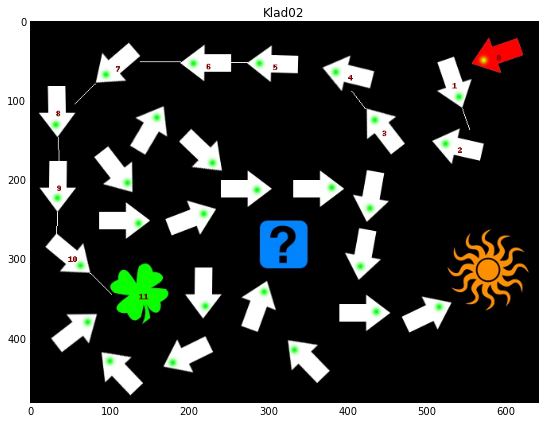

In [1470]:
for i in range(3):
    process(i)